# Atom-Cavity

In [3]:
from math import sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import qutip as q
q.settings.colorblind_safe = True

import ipywidgets as widgets
from ipywidgets import GridspecLayout, interactive, Layout
from IPython.display import display

%matplotlib widget
%matplotlib ipympl
%load_ext line_profiler

## Hamiltonian: Atom-Cavity

![image.png](Img/atom-cav.png)

The **Jaynes-Cumming model** is the simplest possible model of quantum mechanical light-matter interaction, describing a single **two-level atom** interacting with a electromagnetic cavity. The Hamiltonian for this system in the **rotating-wave approximation**:

$H = \hbar\frac{\omega_a}{2}\sigma_z + \hbar\omega_c a^\dagger a + \hbar\frac{\Omega}{2}(\sigma_+ a + \sigma_- a^\dagger)$, for which $\sigma_+ = |e\rangle\langle g|$, $\sigma_- = |g\rangle\langle e|$. 

where $\omega_c$ and $\omega_a$ are the frequencies of the cavity and atom, and $\Omega$ is the interaction coupling.

The implementation in QuTiP of $\sigma_\pm$ assumes that the excited state $|e\rangle$ and ground state $|g\rangle$ are represented as $(1\ 0)^T$ and $(0\ 1)^T$, respectively.

In this example we also consider the coupling of the Jaynes-Cummings model to an external environment, i.e., we need to solve the system using the **Master Equation Solver** 'qutip.mesolve'. The coupling to the environment is described by the creation and anihilation operators $a^\dagger, a$.

#### Initialize
Here we define the initial state and operators for the combined system, which consists of the cavity and the atom. To the size cutoff/size of the Fock space for the cavity, therein also defining the **ladder operators** for the system, therein also the raising and lowering operators for an two-level atom. We make use of the **tensor product**, where the first part refers to the atom and the second part to the cavity. We define the atom to be in the excited state and the cavity in its coherent $\alpha$ state:

- the **atom** initially in the excited state $|e\rangle$,
- the **cavity** field in a coherent state $|\alpha\rangle$,
- a decay rate of the **atom** of $\gamma$,
- a decay rate of **cavity** field of $\kappa$

In [4]:
N = 5 # Cavity, Fock space up to N
M = 2 # Atom, two-level

In [5]:
# Collapse operators
    # Atom
sz = q.tensor(q.sigmaz(), q.identity(N))
sm = q.tensor(q.sigmam(), q.identity(N))
sp = q.tensor(q.sigmap(), q.identity(N))
    # Cavity
a = q.tensor(q.identity(M), q.destroy(N))
ad = q.tensor(q.identity(M), q.create(N))

In [6]:
# Meshgrid for Wigner plot
vec = np.linspace(-3, 3, 50)
xvec, yvec = vec, vec

#### Function
Solve QED of Hamiltonian with initial state:

In [7]:
def solve_qed(om_a=2*np.pi*1, om_c=2*np.pi*1, Om=2*np.pi*0.2, gamma=0, kappa=0, alpha=0, beta=0, n_th_a=0, t=np.linspace(0, 2*np.pi, 100)):
    """
    Solve the cavity QED system using qutip.mesolve.

    Parameters:
    om_a  : atomic transition frequency
    om_c  : cavity resonance frequency
    Om    : Rabi frequency (coupling strength)
    gamma : atomic decay rate
    kappa : cavity decay rate
    alpha : amplitude of the initial coherent state of the cavity 
    beta  : amplitude of the initial excited state of the atom 
    n_th_a: avg number of thermal bath excitation
    t     : array of time values at which to evaluate the state evolution
    """
    
    # Hamiltonian
    H = om_a/2 * sz + om_c * ad*a + Om/2 * (sp * a + sm * ad)
    
    # Initial state, atom in basis and cavity in coherent
    rho0 = q.tensor(q.basis(M, beta), q.basis(N, alpha))

    # Decay, collapse operators (Not faster to implement ne.evaluate())
    c_ops = []

        # Atom annihilation
    if gamma > 0: 
        c_ops.append(sqrt(gamma) * sm)

        # Cavity, operators
            # Photon annihilation
    c_ops.append(sqrt(kappa * (1 + n_th_a)) * a)
    
            # Photon creation
    c_ops.append(sqrt(kappa * n_th_a) * ad)


    # Master equation,
        # give tolerances to make the code faster!
    options = q.Options(store_states=True, rtol=1e-4, atol=1e-6, method="bdf", nsteps=10000)
    result = q.mesolve(H, rho0, t, c_ops, [], options=options)
    return result

In [8]:
result = solve_qed()
%timeit solve_qed()

C:\Users\tobia\Desktop\Clones\SCIQIS-2025-Intro\.venv\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\tobia\Desktop\Clones\SCIQIS-2025-Intro\.venv\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


5.02 ms ± 161 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Linear entropy
Since the dynamics here is undamped ($\alpha, \beta = 0$) the quantum state is pure, and a nonzero entropy of the subsystem demonstrates that the atom is entangled with the cavity field.

$S = 1-Tr(\rho_{red.}(t)^2)$, where $\rho_{red.}$ is the reduced density matrix.

The linear entropy can range between zero, corresponding to a completely pure state, and (1 − 1/d) , corresponding to a completely mixed state, where d is the dimension of the density matrix.

Notice the subsystems return to their original state at an interval.

In [9]:
# Linear entropy
def plot_entropy(result):
    plt.close()
    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    
    entropy_c = [q.entropy_linear(q.ptrace(rho, 0)) for rho in result.states]
    entropy_a = [q.entropy_linear(q.ptrace(rho, 1)) for rho in result.states]
    
        # Plot the subsystem of the Cavity
    axes[0].plot(result.times, entropy_c, color="tab:green")
    axes[0].set_title('Linear Entropy of Cavity')
    axes[0].set_xlabel(r'$t$', fontsize=12)
    axes[0].set_ylabel(r'$S$', fontsize=12)
    axes[0].set_ylim(0, 1)

        # Plot the subsystem of the Atom
    axes[1].plot(result.times, entropy_a, color="tab:orange")
    axes[1].set_title('Linear Entropy of Atom')
    axes[1].set_xlabel(r'$t$', fontsize=12)
    axes[1].set_ylabel(r'$S$', fontsize=12)
    axes[1].set_ylim(0, 1)
    
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    
    plt.tight_layout()
    plt.show()
    return

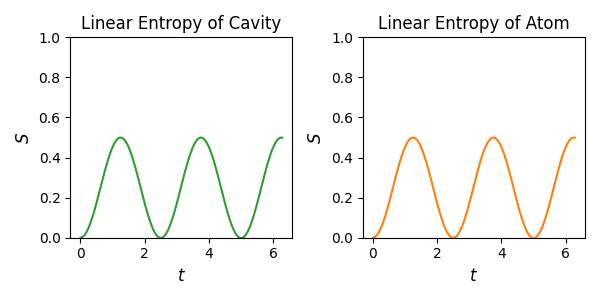

In [10]:
plot_entropy(result)

#### Hilbert space truncation
As a check to make sure that we have use a sufficiently large Hilbert space in the calcuation above we plot the expectation value of the commutator $[a, a^\dagger]=1$, which should be very close to 1 if the Fock-state basis truncation that we used above is OK. Likewise we look at the following expectation of $[\sigma_+, \sigma_-]_+=1$.

For commutator relations of the atom we take note of $[\sigma_+, \sigma_-]=\sigma_z$, which is an Hermitian operator, translating to the expectation value is an observable physical quantity, the inversion $\omega$ of the atom.

In [13]:
# Overveiw of Hilbert space truncation
def plot_trunc(result):
    plt.close()
    fig, axes = plt.subplots(1, 2, figsize=(6,3))
        
        # Plot the subsystem of the Cavity
    axes[0].plot(result.times, [q.expect(q.commutator(a, ad), s) for s in result.states], label=r"$[a^\dagger, a]$", color="tab:green")
    axes[0].set_title(r'Exp. value of Cavity w.')
    axes[0].set_xlabel(r'$t$', fontsize=12)
    axes[0].set_ylim(0, 1.01)
    axes[0].legend()
        
        # Plot the subsystem of the Atom
    axes[1].plot(result.times, [q.expect(q.commutator(sp, sm, kind="anti"), s) for s in result.states], label=r"$[\sigma_+, \sigma_-]_+$", color="tab:orange")
    axes[1].set_title(r'Exp. value of Atom w.')
    axes[1].set_xlabel(r'$t$', fontsize=12)
    axes[1].set_ylim(0, 1.01)
    axes[1].legend()

    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    
    plt.tight_layout()
    plt.show()
    return

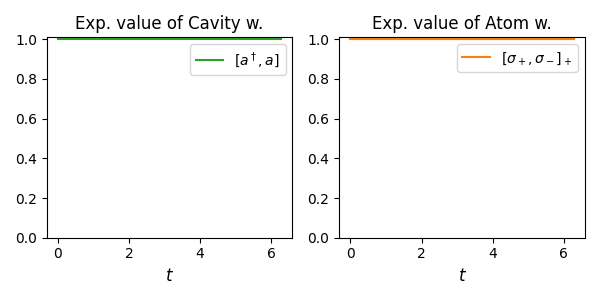

In [14]:
plot_trunc(result)

### States of subsystem
We can get each subsystem from the *result.states* by doing the density matrix trace of the system, tracing out *0* for the atom and *1* for the cavity.

In [15]:
rhos_a = [q.ptrace(rho, 0) for rho in result.states] # States of atom subsystem
rhos_c = [q.ptrace(rho, 1) for rho in result.states] # States of cavity subsystem

### Fock Distribution and Wigner function
See the time evolution of the Fock distribution and the Wigner function, notice we can generate a different states:

- Maximally mixed state of the system, the density matrix is proportional to the identity matrix. Translating physcially to a uniform mixture of the states in an orthonormal basis.
- Fock state of $1$, a creation operator applied to a basis state

In [18]:
def plot_wigner_fock(result):
    plt.close()
    fig, axes = plt.subplots(3, 2, figsize=(6,9))
    
    global xvec, yvec

    x = result.times
    step = [0, 19, 40]
    
    for i in range(3):
        j = step[i]
        tid = x[j]
        
        # Plot the subsystem of the Cavity
            # Fock distribution
        q.plot_fock_distribution(rhos_c[j], ax=axes[i, 1], color="tab:green")
        #axes[i, 1].set_title(r'At time: ' + r"$t=$" + f"{tid:.2f}", x=2)
        axes[i, 1].set_ylim(0, 1.01)
        axes[i, 1].set_xticks(range(N+1))

            # Wigner function
        q.plot_wigner(rhos_c[j], xvec=xvec, yvec=yvec, ax=axes[i, 0], cmap="RdBu_r")#, colorbar=True)
        axes[i, 0].set_title(r'At time: ' + r"$t=$" + f"{tid:.2f}", x=1.1, fontsize = 14)

    fig.suptitle('Wigner func. and Fock dist. at various times \n for the Cavity', fontsize=16)
    
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    
    plt.tight_layout()
    plt.show()
    return

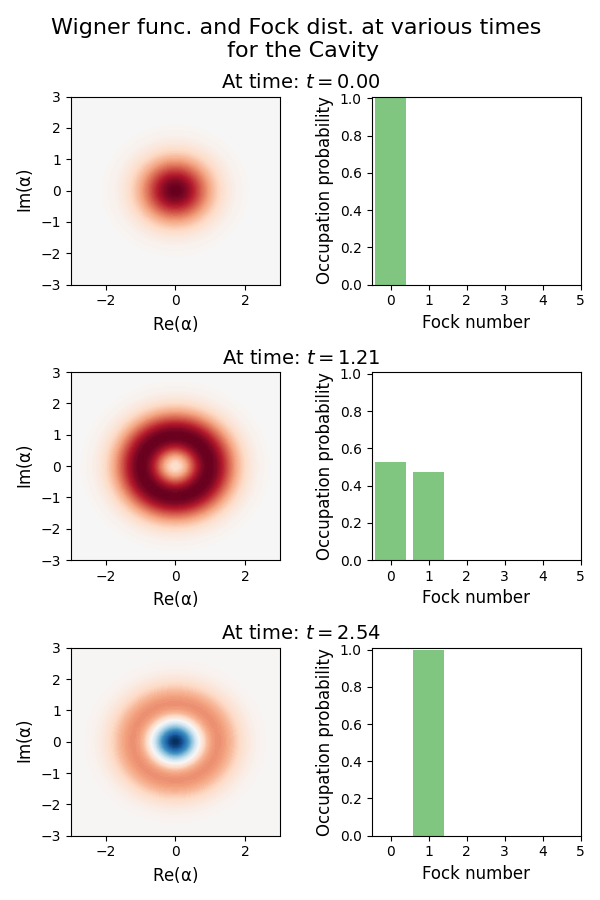

In [19]:
plot_wigner_fock(result)

### Rabi oscillation
The excitation probabilities of the cavity and the atom. We can clearly see how energy is being coherently transferred back and forth between the cavity and the atom.

In [20]:
def plot_rabi(result):
    plt.close()
    fig, axes = plt.subplots(1, 1, figsize=(6,3))

    z1 = [q.expect(ad*a, s) for s in result.states]      # Expect cavity occ. prob.
    z2 = [q.expect(sp*sm, s) for s in result.states]     # Expect atom occ. prob.

        # Plot the subsystem of the Cavity and Atom
    axes.plot(result.times, z1, '-', color="tab:green", label=r"Cavity: $E(a^\dagger a, \phi_c)$")
    axes.plot(result.times, z2, '-', color="tab:orange", label=r"Atom: $E(\sigma_+ \sigma_-, \phi_c)$")
    axes.set_xlim(0, max(result.times))
    axes.set_ylim(0, 1)
    axes.set_title(f'Rabi Osc. at {0}K')
    axes.set_xlabel(r'$\rm{Time}$', fontsize=12)
    axes.set_ylabel(r'$\rm{Occ. prob.}$', fontsize=12)
    axes.legend()
    
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    
    plt.tight_layout()
    plt.show()
    return

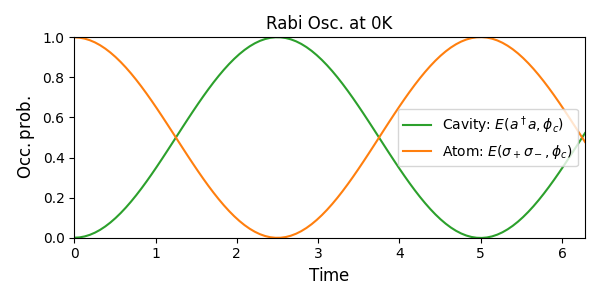

In [21]:
plot_rabi(result)

#### Animation
The following is the function that does the animation within the plot below.

In [23]:
def plot_(result, xvec=None, yvec=None, n_th_a=0, alpha=5, beta=0, method='clenshaw', projection='2d',
                g=sqrt(2), sparse=False, parfor=False, *,
                cmap=None, colorbar=False, fig=None, ax=None):
    """
    Plotting the Wigner function, Fock distribution and occupation probability

    Parameters:
    result: cavity QED master equation results
    xvec  : x-vector of meshgrid for Wigner plot
    yvec  : y-vector of meshgrid for Wigner plot
    n_th_a: avg number of thermal bath excitation
    alpha : amplitude of the initial coherent state of the cavity 
    beta  : amplitude of the initial excited state of the atom 
    """

    # For running the animation and not running into overlapping 
        #of previous we close any plot before 
    plt.close()
    
    fontsize = 12 # Sets frontsize for axis and titles

    # Some data results
    x, len_x = result.times, len(result.times)           # Time 
    z1 = [q.expect(ad*a, s) for s in result.states]      # Expect cavity occ. prob.
    z2 = [q.expect(sp*sm, s) for s in result.states]     # Expect atom occ. prob.
    rhos_c = [q.ptrace(rho, 1) for rho in result.states] # States of cavity subsystem
    rhos_m = [q.ptrace(rho, 0) for rho in result.states] # States of atom subsystem
    
        # List for keeping data
    wlims_c = list()  # List of Wigner limit of cavity
    wlims_m = list()  # List of Wigner limit of atom
    
    Ws_c = list() # List of Wigner values cavity
    Ws_m = list() # List of Wigner values atom
    
    Fs_c = list() # List of Fock values cavity
    Fs_m = list() # List of Fock values atom

        # Gathering the data
    for rho_m, rho_c in zip(rhos_m, rhos_c):
        W0_c = q.wigner(
            rho_c, xvec, yvec, method=method,
            g=g, sparse=sparse, parfor=parfor
        )
    
        W_c, yvec = W0_c if isinstance(W0_c, tuple) else (W0_c, yvec)
        Ws_c.append(W_c)

        W0_m = q.wigner(
            rho_m, xvec, yvec, method=method,
            g=g, sparse=sparse, parfor=parfor
        )
    
        W_m, yvec = W0_m if isinstance(W0_m, tuple) else (W0_m, yvec)
        Ws_m.append(W_m)

        wlims_c.append(abs(W_c).max())
        wlims_m.append(abs(W_m).max())
        
        F0_c = np.real(rho_c.diag())
        Fs_c.append(F0_c)

        F0_m = np.real(rho_m.diag())
        Fs_m.append(F0_m)
    
    offset=0.5 # Offset for Fock dist. plot
    
    # Create the figure and axes
    fig = plt.figure(figsize=(7,7))
    axes1 = plt.subplot(313)
    axes2 = plt.subplot(321)
    axes3 = plt.subplot(322)
    axes4 = plt.subplot(323)
    axes5 = plt.subplot(324)

        # Adjust spacing
    plt.subplots_adjust(wspace=.4)
    plt.subplots_adjust(hspace=.7)
    
    # Set up the plot's initial state
        # Oscillation of occ. prob.
    axes1.set_xlim(0, max(x))
    axes1.set_title(f'Rabi Osc. at {n_th_a}K')
    axes1.set_xlabel(r'$\rm{Time}$', fontsize=fontsize)
    axes1.set_ylabel(r'$\rm{Norm. Occ. prob.}$', fontsize=fontsize)
        
        # Wigner plot atom
    axes2.set_title('Wigner Func. of Atom')
    axes2.set_xlabel(r'$\rm{Re}(\alpha)$', fontsize=fontsize)
    axes2.set_ylabel(r'$\rm{Im}(\alpha)$', fontsize=fontsize)

        # Fock dist. atom
    axes3.set_ylim(0, 1)
    axes3.set_xlim(np.arange(-.5 + offset, M + offset, M))
    axes3.set_title('Fock Dist. of Atom')
    axes3.set_xlabel('Fock number', fontsize=fontsize)
    axes3.set_ylabel('Occ. prob.', fontsize=fontsize)
    axes3.set_xticks(range(M+1))

        # Wigner plot cavity
    axes4.set_title('Wigner Func. of Cavity')
    axes4.set_xlabel(r'$\rm{Re}(\alpha)$', fontsize=fontsize)
    axes4.set_ylabel(r'$\rm{Im}(\alpha)$', fontsize=fontsize)

        # Fock dist. cavity
    axes5.set_ylim(0, 1)
    axes5.set_xlim(np.arange(-.5 + offset, N + offset, N))
    axes5.set_title('Fock Dist. of Cavity')
    axes5.set_xlabel('Fock number', fontsize=fontsize)
    axes5.set_ylabel('Occ. prob.', fontsize=fontsize)
    axes5.set_xticks(range(N+1))

        # Setup for colorbar for Wigner plot        
    if colorbar:
        shrink = 0.75
        
        cax_c, kw = mpl.colorbar.make_axes(axes2, shrink=shrink, pad=.05)
        cax_m, kw = mpl.colorbar.make_axes(axes4, shrink=shrink, pad=.05)
    
    # Create a list to hold the artists for each frame
    artists = []
    
    # Initialize and generate the data and artists for all frames
    xdata1, ydata1 = [], []
    xdata2, ydata2 = [], []
    
    for frame, W_c, W_m, F_c, F_m, wlim_c, wlim_m in zip(np.arange(0,len_x,1), Ws_c, Ws_m, Fs_c, Fs_m, wlims_c, wlims_c):
        frame = int(frame)

        # Oscillation of occ. prob. - line 
            # Append new data for each line
        xdata1.append(x[frame])
        ydata1.append(z1[frame])
    
        xdata2.append(x[frame])
        ydata2.append(z2[frame])
    
            # Plot the lines for the current frame
        ln1, = axes1.plot(xdata1, ydata1, '-', color="tab:green")
        ln2, = axes1.plot(xdata2, ydata2, '-', color="tab:orange")
        
        # Wigner plot - contour
        norm_c = mpl.colors.Normalize(-wlim_c, wlim_c)
        norm_m = mpl.colors.Normalize(-wlim_m, wlim_m)

        shrink = 0.75
        cbar_c = mpl.colorbar.ColorbarBase(cax_c, cmap=cmap, norm=norm_c)
        cbar_m = mpl.colorbar.ColorbarBase(cax_m, cmap=cmap, norm=norm_m)
        
        cf_m = axes2.contourf(xvec, yvec, W_m, 100, norm=norm_m, cmap=cmap)
        cf_c = axes4.contourf(xvec, yvec, W_c, 100, norm=norm_c, cmap=cmap)

        # Fock dist. - Histogram
        bars_m = axes3.bar(np.arange(offset, offset + M) - .4, F_m,
               color="tab:orange", alpha=0.6, width=0.8)
        bars_c = axes5.bar(np.arange(offset, offset + N) - .4, F_c,
               color="tab:green", alpha=0.6, width=0.8)

        bars = np.append(bars_c, bars_m)
        
        # Add the artists for the current frame to the list
        artists.append(np.append(np.array([ln1, ln2, cf_c, cf_m]), bars))

    # Create the animation
    anim = animation.ArtistAnimation(fig, artists, interval=len_x, blit=True)

    # Clean up for plot setting missing stuff
    ln1.set_label('Cavity')
    ln2.set_label('Atom')
    axes1.legend(loc='upper right', fontsize='small')
    
    # The ipynb window, bigger
    fig.canvas.layout.width = '7in'
    fig.canvas.layout.height= '8in'
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    
    # Display animation
    plt.show()
    
    return fig, anim

#### Interaction
The following is the function that can be interacted with for the plot below. The sliders that can be changed to make it interactive. The grid of sliders above the plots themselvs (Note it takes a little bit before it loads the new animation/plots).

In [24]:
def plot_interactive(gamma, kappa, n_th_a, alpha, beta, om_a, om_c, Om):
    """
    Function for interactively plotting

    Parameters:
    om_a  : atomic transition frequency
    om_c  : cavity resonance frequency
    Om    : Rabi frequency (coupling strength)
    gamma : atomic decay rate
    kappa : cavity decay rate
    alpha : amplitude of the initial coherent state of the cavity 
    beta  : amplitude of the initial excited state of the atom 
    n_th_a: avg number of thermal bath excitation
    """

    # Adjust values for QED
    om_a = 2*np.pi * om_a    
    om_c = 2*np.pi * om_c    
    Om = 2*np.pi * Om        
    gamma = gamma/100        
    kappa = kappa/10      

    # Get result of master equation
    result = solve_qed(om_a, om_c, Om, gamma, kappa, alpha, beta, n_th_a)

    # Get the plots
    global xvec, yvec # Previously done, time saving
    fig, ani = plot_(result, xvec, yvec, n_th_a, alpha, beta, method='clenshaw', # projection='2d',
                            g=np.sqrt(2), sparse=False, parfor=True,
                            cmap='RdBu_r', colorbar=True, fig=None, ax=None)
    return fig, ani

In [29]:
# Sliders for interactive plot
def sliders(N, M): 
    """
    Interactive sliders for plot

    Parameters:
    N     : size of Fock space, cavity
    M     : size of Fock space, atom (two-level)

    Sliders:
    om_a  : atomic transition frequency
    om_c  : cavity resonance frequency
    Om    : Rabi frequency (coupling strength)
    gamma : atomic decay rate
    kappa : cavity decay rate
    alpha : amplitude of the initial coherent state of the cavity 
    beta  : amplitude of the initial excited state of the atom 
    n_th_a: avg number of thermal bath excitation
    """
    
    slider_gamma = widgets.FloatSlider(value=0.5,
                                     min=0.,
                                     max=1.,
                                     step=0.01,
                                     description='gamma:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='.1f')
    
    slider_kappa = widgets.FloatSlider(value=0.5,
                                     min=0.,
                                     max=1.,
                                     step=0.01,
                                     description='kappa:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='.1f')
    
    slider_n_th_a = widgets.IntSlider(value=2,
                                     min=0,
                                     max=300,
                                     step=1,
                                     description='temp.:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='d')
    
    slider_alpha = widgets.IntSlider(value=0,
                                     min=0,
                                     max=N,
                                     step=1,
                                     description='alpha:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='d')
    
    slider_beta = widgets.IntSlider(value=0,
                                     min=0,
                                     max=M,
                                     step=1,
                                     description='beta:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='d')
    
    slider_om_a = widgets.FloatSlider(value=1.,
                                     min=0.,
                                     max=1.,
                                     step=.1,
                                     description='om_a:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='.1f')
    
    slider_om_c = widgets.FloatSlider(value=1.,
                                     min=0.,
                                     max=1.,
                                     step=.1,
                                     description='om_c:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='.1f')
    
    slider_Om = widgets.FloatSlider(value=.2,
                                     min=0.,
                                     max=1.,
                                     step=.1,
                                     description='Om:',
                                     disabled=False,
                                     continuous_update=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='.1f')
    return slider_gamma, slider_kappa, slider_n_th_a, slider_alpha, slider_beta, slider_om_a, slider_om_c, slider_Om

def grid_layout(widget_list):
    # Use GridspecLayout to create the 2-column grid
    # The number of rows is calculated based on the number of widgets
    n_widgets = len(widget_list)
    n_cols = 2
    n_rows = (n_widgets + n_cols - 1) // n_cols
    
    grid = GridspecLayout(n_rows, n_cols, height='auto')
    
    # Place the widgets into the grid
    for i, widget in enumerate(widget_list):
        row = i // n_cols
        col = i % n_cols
        grid[row, col] = widget
    return grid

In [32]:
# Sliders widgets
slider_gamma, slider_kappa, slider_n_th_a, slider_alpha, slider_beta, slider_om_a, slider_om_c, slider_Om = sliders(N, M)

# List of all widgets
widget_list = [slider_gamma, slider_kappa, slider_n_th_a, slider_alpha,
              slider_beta, slider_om_a, slider_om_c, slider_Om]

# Create the interactive widget without displaying it
out = interactive(plot_interactive,
         gamma = slider_gamma,
         kappa = slider_kappa,
         n_th_a = slider_n_th_a,
         alpha = slider_alpha,
         beta = slider_beta,
         om_a = slider_om_a,
         om_c = slider_om_c,
         Om = slider_Om,
         plot_field=True, continuous_update=False)

grid = grid_layout(widget_list)

# Display the grid and the interactive plot output
display(grid)
display(out.children[-1])

GridspecLayout(children=(FloatSlider(value=0.5, continuous_update=False, description='gamma:', layout=Layout(g…

Output()

- Show maximally mixed state -> temp. goes large

In [33]:
plt.close()